In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
def fetch_data(ticker, start_date):
    """
    Fetch historical monthly price data using yfinance.

    Parameters:
    ticker: Stock or asset ticker symbol
    start_date: The start date for data retrieval (format: 'YYYY-MM-DD')
    
    Returns:
    A DataFrame with monthly closing prices, indexed by date
    """
    # Set the current date as the end date
    end_date = pd.Timestamp.now().strftime('%Y-%m-%d')
    
    # Download the data from yfinance with monthly intervals
    data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
    
    # Select only the 'Close' column and clean up the DataFrame
    data = data[['Close']].copy()
    data.rename(columns={'Close': 'Prices'}, inplace=True)
    data.index.name = 'Dates'
    
    return data

def forecast_until_date(future_date, signals):
    """
    Forecast prices using the Holt-Winters Exponential Smoothing method.

    Parameters:
    future_date: The date until which to forecast (format: 'YYYY-MM-DD')
    signals: DataFrame with historical prices (indexed by date)
    
    Returns:
    A tuple with a forecast index (dates) and the corresponding forecasted prices
    """
    # Initialize the Holt-Winters model (trend and seasonal additive, monthly data)
    model = ExponentialSmoothing(signals['Prices'], trend='add', seasonal='add', seasonal_periods=12)
    
    # Fit the model to the historical data
    fitted_model = model.fit()
    
    # Calculate the number of months between the last known data point and the future date
    last_date = signals.index[-1]
    forecast_periods = (pd.to_datetime(future_date).year - last_date.year) * 12 + (pd.to_datetime(future_date).month - last_date.month)
    
    # Generate the date index for the forecast period
    forecast_index = pd.date_range(last_date, periods=forecast_periods + 1, freq='M')[1:]
    
    # Generate the forecast for the calculated number of periods
    forecast = fitted_model.forecast(steps=forecast_periods)
    
    return forecast_index, forecast

def estimate_price(target_date, signals):
    """
    Estimate the price for a specific future date based on the forecast.

    Parameters:
    target_date: The target date for price estimation (format: 'YYYY-MM-DD')
    signals: DataFrame with historical prices (indexed by date)
    
    Reutrns:
    The estimated price on the target date
    """
    # Convert the target date to a datetime object
    target_date = pd.to_datetime(target_date)
    
    # Forecast prices up to the target date
    forecast_index, forecast = forecast_until_date(target_date, signals)
    
    # Check if the target date is within the forecast range
    if target_date in forecast_index:
        # Return the forecasted price for the target date
        return forecast[forecast_index.get_loc(target_date)]
    else:
        # Raise an error if the target date is beyond the forecast range
        raise ValueError("Date too far in the future for current extrapolation")

def plot_forecast(ticker, signals, forecast_index, forecast, target_date=None, target_price=None):
    """
    Plot historical prices along with the forecasted prices, and mark the target date.

    Parameters:
    signals: DataFrame with historical prices
    forecast_index: Forecast date index
    forecast: Forecasted prices
    target_date: Specific target date to highlight in the plot (optional)
    target_price: The estimated price for the target date (optional)
    """
    plt.figure(figsize=(12, 6))
    
    # Plot historical prices
    plt.plot(signals.index, signals['Prices'], label='Historical Prices', color='blue')
    
    # Plot forecasted prices
    plt.plot(forecast_index, forecast, label='Forecasted Prices', color='orange', linestyle='--')
    
    # Highlight the specific target date and price if provided
    if target_date is not None and target_price is not None:
        plt.scatter(target_date, target_price, color='red', marker='o', label=f'Estimated Price on {target_date.strftime("%Y-%m-%d")}')
        plt.axvline(target_date, color='red', linestyle=':', alpha=0.7)
    
    # Plot formatting
    plt.title(f"{ticker} Price Forecast for {forecast_index[-1].strftime('%Y-%m-%d')}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

[*********************100%%**********************]  1 of 1 completed
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\natha\AppData\Local\Temp\ipykernel_17120\3006003909.py:47: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(last_date, periods=forecast_periods + 1, freq='M')[1:]
C:\Users\natha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\natha\AppData\Local\Temp\ipykernel_17120\3006003909.py:47: Futu

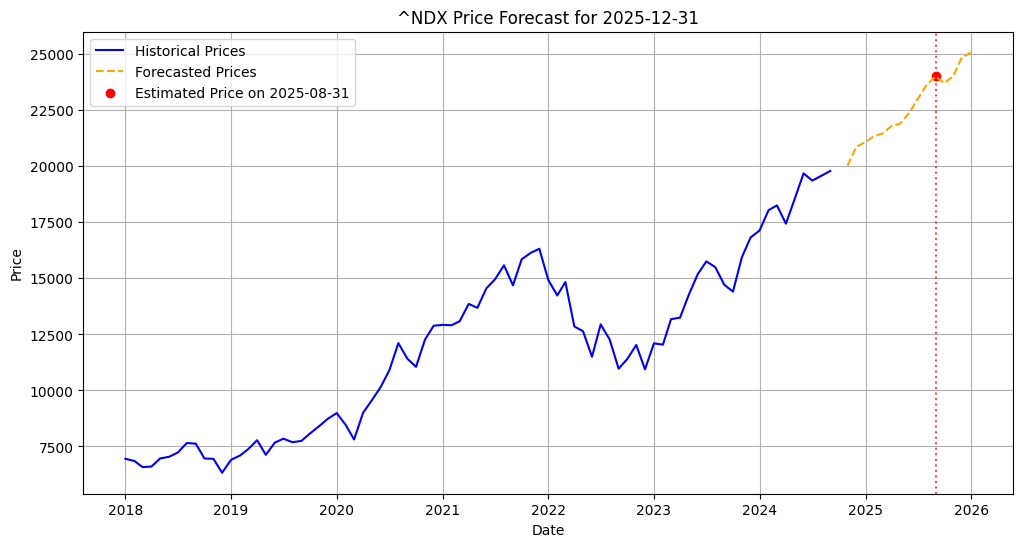

Estimated price on 2025-08-31: 24013.92


In [3]:
# Example usage
ticker = "^NDX"
start_date = "2018-01-01"

# Fetch stock data
signals = fetch_data(ticker, start_date)
    
# Example: Forecast until a specific future date
forecast_date = '2025-12-01'
target_date = '2025-08-31' # Onyl use date for end of each month
forecast_index, forecast_prices = forecast_until_date(forecast_date, signals)
estimated_price = estimate_price(target_date, signals)

# Plot historical prices and forecast with the estimated target price highlighted
plot_forecast(ticker, signals, forecast_index, forecast_prices, target_date=pd.to_datetime(target_date), target_price=estimated_price)

# Example: Estimate price for a specific future date
print(f"Estimated price on {target_date}: {estimated_price:.2f}")